# Классификация ирисов Фишера методом KNN

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [2]:
irises = load_iris()
data = irises['data'][:, 2:]
target = irises['target']
target_names = irises['target_names']

In [3]:
def my_fit(data, target):
    loo = LeaveOneOut()
    errors = [0 for i in range(0, len(data)-1)]
    for train_index, test_index in loo.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        for i in range(1, len(data)):
            clf = KNeighborsClassifier(n_neighbors=i)
            clf.fit(X_train, y_train)
            errors[i-1] += (clf.predict(X_test) != y_test)[0] / len(data)
    return errors

In [4]:
n_neighbors = [i for i in range(1,len(data))]
errors = my_fit(data, target)
n = errors.index(min(errors)) + 1
point_of_min = [n, errors[n-1]]

clf = KNeighborsClassifier(n_neighbors=n)
clf.fit(data, target)
values = np.array([[i, j] for i in np.arange(0, 7, 0.1) for j in np.arange(0, 2.6, 0.1)])

predicts = clf.predict(values)

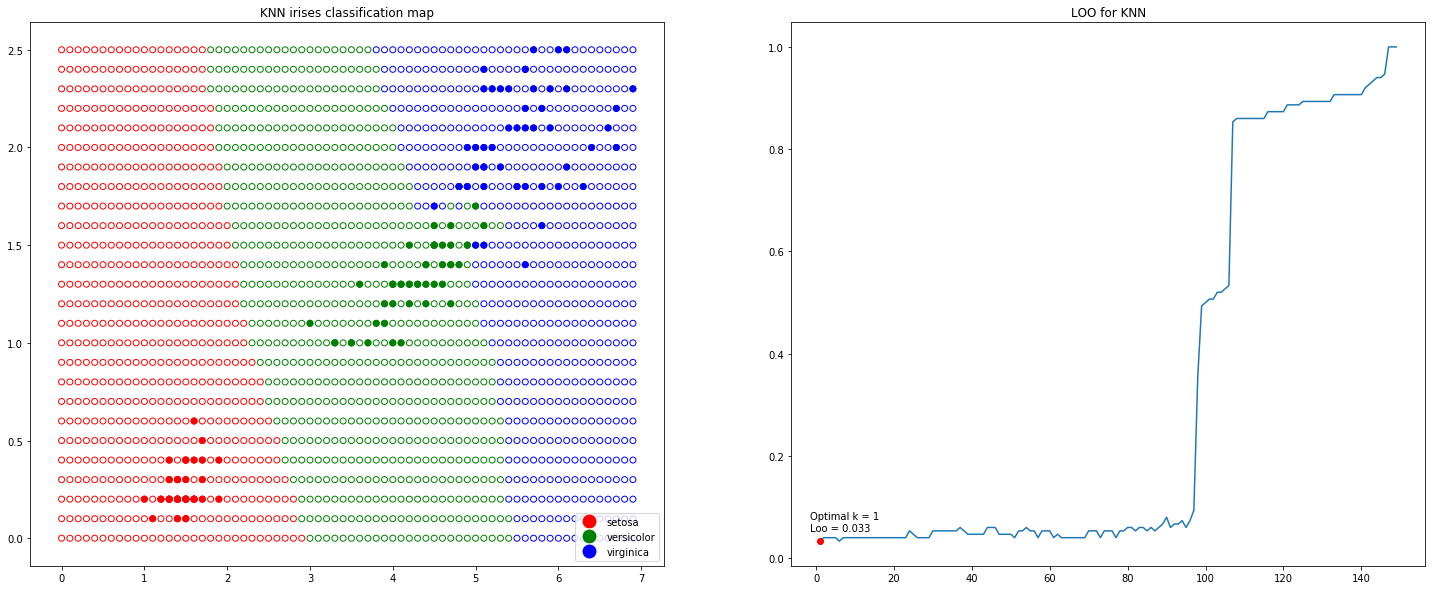

In [5]:
colors = np.array(['red', 'green', 'blue'])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

ax1.scatter(data[:, 0], data[:, 1], color=colors[target])
handlers = [Line2D([0], [0], marker='o', color='w', label=target_names[i], 
            markerfacecolor=colors[i], markersize=15) for i in range(0, len(colors))]
ax1.legend(handles=handlers, loc='lower right')
ax1.scatter(values[:, 0], values[:, 1], edgecolors=colors[predicts], facecolors='none')
ax1.set_title('KNN irises classification map')


ax2.plot(n_neighbors, errors)
ax2.plot(point_of_min[0], point_of_min[1], 'or', color='red')
s = 'Optimal k = ' + str(n) + '\nLoo = ' + str(round(errors[n-1], 3))
ax2.annotate(s=s, xy=(point_of_min[0], point_of_min[1]), textcoords='offset points', xytext=(-10, 10))
ax2.set_title('LOO for KNN')

plt.show()

# Классификация ирисов Фишера методом парзеновского окна

In [6]:
from sklearn.neighbors import RadiusNeighborsClassifier

In [7]:
def my_fit(data, target, kernel):
    loo = LeaveOneOut()
    errors = [0 for i in range(0, len(data)-1)]
    for train_index, test_index in loo.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        for i in range(1, len(data)):
            clf = KNeighborsClassifier(radius=i, weights=kernel)
            clf.fit(X_train, y_train)
            errors[i-1] += (clf.predict(X_test) != y_test)[0] / len(data)
    return errors